## Statistics of the (c)RTRBM

In [1]:
import scipy.io
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import sys
sys.path.append('D:\RU\OneDrive\Intern\Master')

%matplotlib inline
from plots import * # * means import all
from RTRBM_batches_in_funcs import RTRBM

Load data

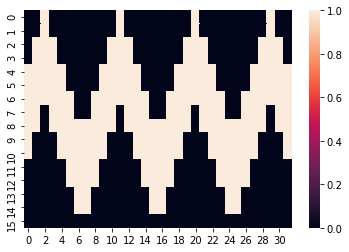

In [2]:
mat = scipy.io.loadmat('/home/sebastian/Desktop/RTRBM/data\bouncing_balls.mat')
data = torch.tensor(mat['data'])
sns.heatmap(data[:,:,1])
N_V = data.shape[0]


### Mean and variance of the parameters in a cRTRBM during training

100%|██████████| 10000/10000 [2:04:32<00:00,  1.34it/s] 


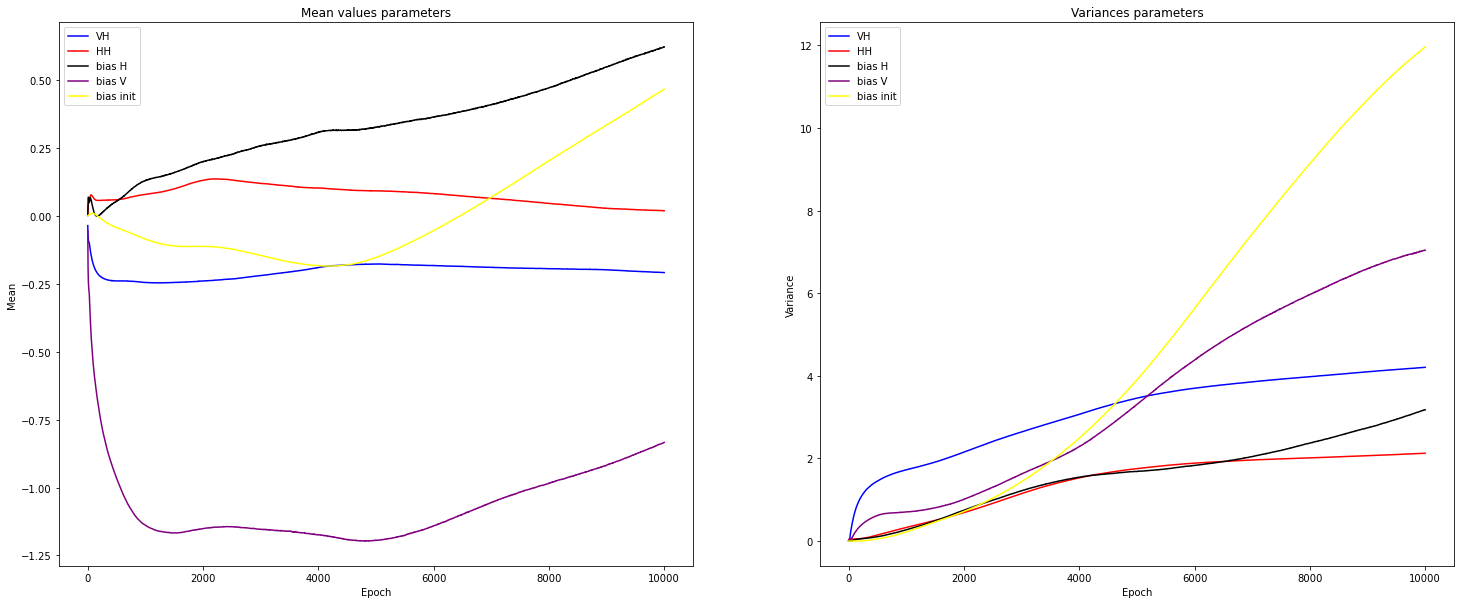

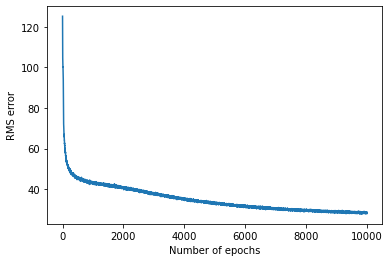

In [5]:
n_epochs = 10000

rtrbm_1 = RTRBM(data, N_H)

mean_HH = torch.zeros(n_epochs)
mean_VH = torch.zeros(n_epochs)
mean_b_v = torch.zeros(n_epochs)
mean_b_h = torch.zeros(n_epochs)
mean_b_init = torch.zeros(n_epochs)

var_HH = torch.zeros(n_epochs)
var_VH = torch.zeros(n_epochs)
var_b_v = torch.zeros(n_epochs)
var_b_h = torch.zeros(n_epochs)
var_b_init = torch.zeros(n_epochs)

errors = torch.zeros(n_epochs)
HH = torch.zeros(N_H, N_H, n_epochs)
VH = torch.zeros(N_V, N_H, n_epochs)

for i in tqdm(range(n_epochs)):
    rtrbm_1.learn(
              spars_penalty=3e-5, x=2, sp=True,
              activationFunction=torch.sigmoid,
              learning_rate=0.005, learning_rate_decay=True,
              momentum=0.85,
              weightcost=0.0002,
              CDk=10,
              n_epochs=1,
              batchsize=128,
              disable_tqdm=True)
    
    mean_HH[i] = torch.mean(rtrbm_1.W_acc)
    mean_VH[i] = torch.mean(rtrbm_1.W)
    mean_b_v[i] = torch.mean(rtrbm_1.b_V)
    mean_b_h[i] = torch.mean(rtrbm_1.b_H)
    mean_b_init[i] = torch.mean(rtrbm_1.b_init)
    
    var_HH[i] = torch.var(rtrbm_1.W_acc)
    var_VH[i] = torch.var(rtrbm_1.W)
    var_b_v[i] = torch.var(rtrbm_1.b_V)
    var_b_h[i] = torch.var(rtrbm_1.b_H)
    var_b_init[i] = torch.var(rtrbm_1.b_init)
    
    errors[i] = rtrbm_1.errors
    VH[:, :, i] = rtrbm_1.W.T
    HH[:, :, i] = rtrbm_1.W_acc
        
fig, axes = plt.subplots(1,2,figsize=(25,10))
ax = axes[0]
ax.plot(mean_VH, '-', color='b', label='VH')
ax.plot(mean_HH, '-', color='r', label='HH')
ax.plot(mean_b_h, '-', color='k', label='bias H')
ax.plot(mean_b_v, '-', color='purple', label='bias V')
ax.plot(mean_b_init, '-', color='yellow', label='bias init')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean')
ax.set_title('Mean values parameters')

ax = axes[1]
ax.plot(var_VH, '-', color='b', label='VH')
ax.plot(var_HH, '-', color='r', label='HH')
ax.plot(var_b_h, '-', color='k', label='bias H')
ax.plot(var_b_v, '-', color='purple', label='bias V')
ax.plot(var_b_init, '-', color='yellow', label='bias init')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Variance')
ax.set_title('Variances parameters')
plt.show()

plt.plot(errors) 
plt.xlabel("Number of epochs")
plt.ylabel("RMS error")
plt.show()

An infer example

In [1]:
sample = 2
vt_sampled, rt_sampled = rtrbm_1.infer(data[:,:8,sample],
                                        pre_gibbs_k=100,
                                        gibbs_k=1,
                                        mode=2,
                                        t_extra=0)

plot_true_sampled(data[:,:,sample], rtrbm_1.visible_to_hidden(data[:,:,sample]), vt_sampled, rt_sampled)

NameError: name 'rtrbm_1' is not defined

### First and second moments of the trained cRTRBM

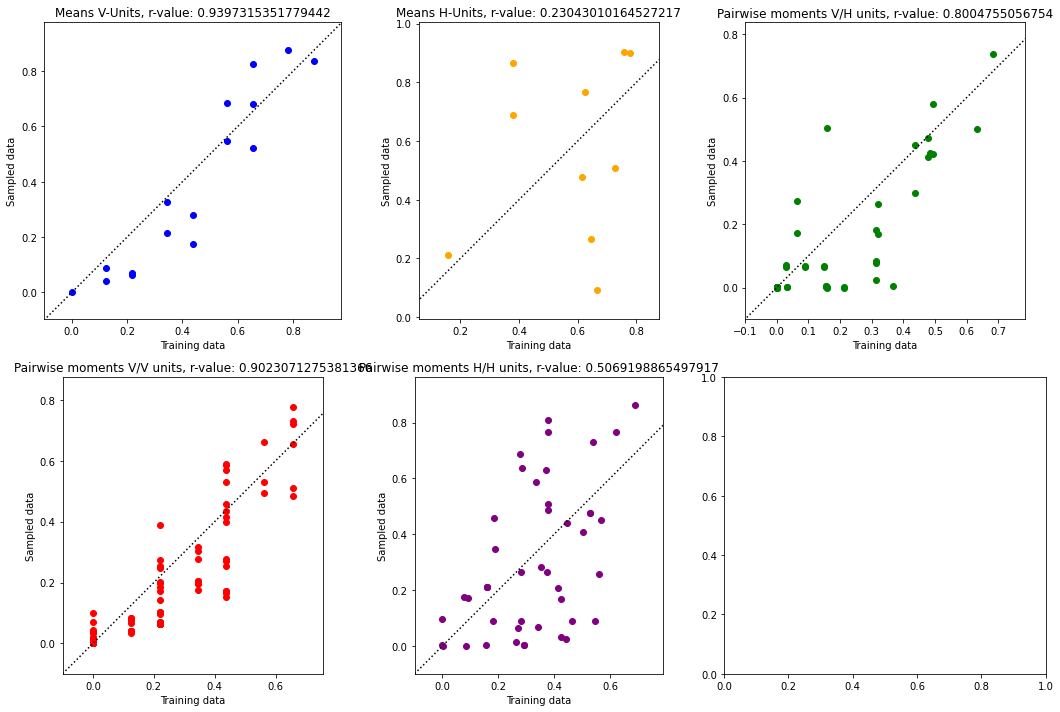

In [49]:
%matplotlib inline

plot_moments(data[:,:,sample].float(), rtrbm_1.rt, vt_sampled, rt_sampled)

### Weigh distribution of VH and HH

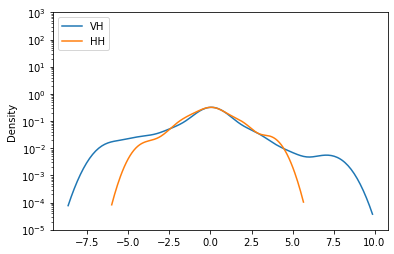

In [50]:
plot_weights_log_distribution_compare(rtrbm_1.W, rtrbm_1.W_acc, label1='VH', label2='HH', ymin=10e-6, ymax=1000)

### Weigth development over time

<IPython.core.display.Javascript object>


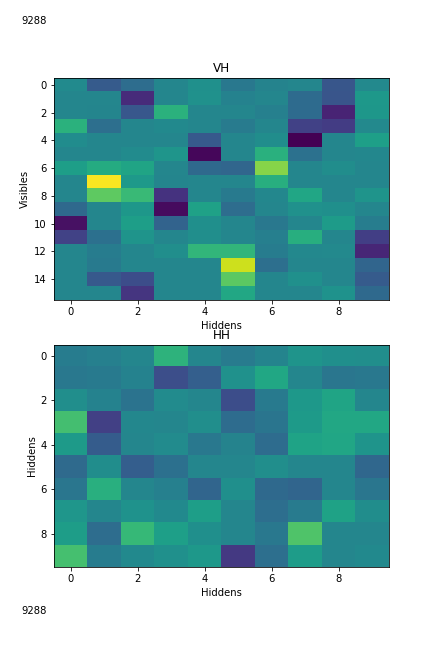

In [51]:
%matplotlib notebook

import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

snapshots_VH = [ VH[:,:,i] for i in range(n_epochs) ] 
snapshots_HH = [ HH[:,:,i] for i in range(n_epochs) ] 

#plt.clf()
fig, axes = plt.subplots(2,1,figsize=(6,9))
im_VH = axes[0].imshow(snapshots_VH[0], interpolation='none', aspect='auto', \
                       vmin = VH.ravel().min(), vmax = VH.ravel().max())
im_HH = axes[1].imshow(snapshots_HH[0], interpolation='none', aspect='auto', \
                       vmin = VH.ravel().min(), vmax = VH.ravel().max())

# add another axes at the top left corner of the figure
axtext = fig.add_axes([0.0,0.95,0.1,0.05])
# turn the axis labels/spines/ticks off
axtext.axis("off")

time = axtext.text(0.5,0.5, str(0), ha="left", va="top")
time1 = axtext.text(0.5,-18, str(0), ha="left", va="bottom")


axes[0].set_xlabel('Hiddens')
axes[0].set_ylabel('Visibles')
axes[0].set_title('VH')

axes[1].set_xlabel('Hiddens')
axes[1].set_ylabel('Hiddens')
axes[1].set_title('HH')

def animate_func(i):
    im_VH.set_array(snapshots_VH[i])
    im_HH.set_array(snapshots_HH[i])
    time.set_text(str(i))
    time1.set_text(str(i))

    return [im_VH, im_HH, time, time1]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = n_epochs,
                               interval = 1, # in ms
                               blit=False)
                               
plt.show()

Nu naar de verandering van de weight distribution per epoch

<IPython.core.display.Javascript object>


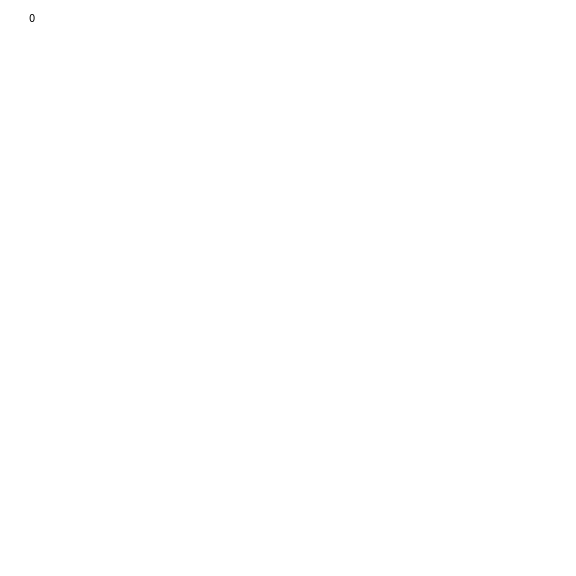

<IPython.core.display.Javascript object>


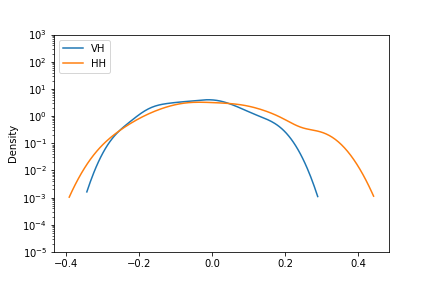

In [60]:
import seaborn as sns

snapshots_VH = [ VH[:,:,i] for i in range(n_epochs) ] 
snapshots_HH = [ HH[:,:,i] for i in range(n_epochs) ] 

#plt.clf()
fig = plt.figure( figsize=(8,8) )
im_WD = plot_weights_log_distribution_compare(snapshots_VH[0], snapshots_HH[0], label1='VH', label2='HH', ymin=10e-6, ymax=1000)

# add another axes at the top left corner of the figure
axtext = fig.add_axes([0.0,0.95,0.1,0.05])
# turn the axis labels/spines/ticks off
axtext.axis("off")

time = axtext.text(0.5,0.5, str(0), ha="left", va="top")


#im_WD.set_xlabel('Weights')
#im_WD.set_ylabel('Density')
#im_WD.set_title('Weight distribution')


def animate_func(i):
    im_WD.set_array(snapshots_VH[i], snapshots_HH[i])
    time.set_text(str(i))
    
    return [im_WD, time]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = n_epochs,
                               interval = 10, # in ms
                               blit=False)
                               
plt.show()

#ax.set_ylim([10e-4,1])

### Mutual information & correlation in time

In [ ]:
%matplotlib inline
MU = torch.zeros(v_prob.shape[1])
for t in range(v_prob.shape[1]-1):
    MU[t] = - torch.matmul(v_prob[:,t].T, v_prob[:,t+1]) * torch.log(torch.matmul(v_prob[:,t].T, v_prob[:,t+1]) / \
                                                                      (torch.sum(v_prob[:,t]) + torch.sum(v_prob[:,t+1])) )
    Corr[t] = np.corrcoef(v_prob[:,t], v_prob[:,t+1])
    
fig, axes = plt.subplots(1,2,figsize=(6,9))

MU_fig = axes[0].plot(MU)                     
Corr_fig = axes[1].plot(Corr)

axes[0].set_xlabel('Time')
axes[0].set_ylabel('MU')
axes[0].set_title('Mutual information')

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Corr')
axes[1].set_title('Correlation')
plt.show()
